In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import defaultdict
from tqdm import tqdm

%matplotlib inline

In [2]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def matrix_norm(m:np.ndarray, frobenius:bool):
    assert len(m.shape) == 2
    if frobenius:
        ## frobenius norm
        return np.linalg.norm(m)
    ## spectral norm
    return np.linalg.norm(m, 2)


def covariance_generator(d:int):
    rnd = np.random.uniform(low=-0.5, high=0.5, size=d*d).reshape(d, d)
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    return mat


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, var:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    var (float): The variance proxy of the noise
    """
    if not var:
        assert distribution in ["gaussian", "uniform"]
    
    if distribution == "gaussian":
        if not var:
            var = 1
        noise = np.random.normal(loc=0, scale=var, size=size) 
    elif distribution == "uniform":
        if not var:
            low = -1
            high = 1
            var = ((high - low) ** 2) / 12
        else:
            low = -np.sqrt(3 * var)
            high = np.sqrt(3 * var)
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        var = 1
        noise = rademacher(size=size)
    return noise, var

In [3]:
def sampleGenerator(num_samples:int, obs_dim:int, latent_dim:int, noise_var:float=None, noise_dist:str="gaussian",
                    feature_bound:float=None, matrix_lower_bound:float=None, matrix_upper_bound:float=None, disjoint:bool=True, seed:int=7777):
    """
    num_samples: the number of samples
    obs_dim: the dimension of an observable context
    latent_dim: the dimension of a latent context
    noise_var: variance of the noise added to the observable contexts
    feature_bound: the upper bound of the norm of the observable contexts
    matrix_bound: the upper bound of the spectral norm of the encoder matrix
    disjoint: represents if the latent features are disjoint are not
    """
    np.random.seed(seed)
    
    ## latent features
    Z_cov = covariance_generator(latent_dim)
    Z = np.random.multivariate_normal(mean=np.ones(latent_dim), cov=Z_cov, size=num_samples)
    
    ## mapping noise
    context_noise, var = subgaussian_noise(distribution=noise_dist, size=num_samples*obs_dim, var=noise_var)
    context_noise = context_noise.reshape(-1, d)
    
    ## latent mapping decoder and observable features
    if disjoint:
        A = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.identity(latent_dim), size=obs_dim)
    else:
        A_cov = covariance_generator(latent_dim)
        A = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=A_cov, size=obs_dim)

    if feature_bound:
        for i in range(Z.shape[0]):
            row = Z[i, :]
            norm = l2norm(row)
            row *= (feature_bound / norm)
            Z[i, :] = row
    
    if matrix_lower_bound:
        u, sigma, v = np.linalg.svd(A)
        sigma = sigma - min(sigma) + matrix_lower_bound
        new_sigma = np.zeros(A.shape)
        for i in range(sigma.shape[0]):
            new_sigma[i, i] = sigma[i]
        A = u @ new_sigma @ v
    
    if matrix_upper_bound:
        max_singular = np.linalg.norm(A, 2)
        A *= (matrix_upper_bound / max_singular)
    
    X = Z @ A.T + context_noise

    if feature_bound:
        for i in range(X.shape[0]):
            row = X[i, :]
            norm = l2norm(row)
            row *= (feature_bound / norm)
            X[i, :] = row
    
    ## encoder bounded by C_B
    B = left_pseudo_inverse(A)
    
    return B, Z, X, context_noise

In [4]:
def param_generator(dimension:int, distribution:str="gaussian", bound:float=1.):
    if distribution == "gaussian":
        cov = covariance_generator(dimension)
        mean = np.random.randint(-1, 2, size=dimension)
        param = np.random.multivariate_normal(mean=mean, cov=cov)
    else:
        # uniform
        param = np.random.random(dimension)
        
    if bound:
        norm = l2norm(param)
        param *= (bound / norm)
    
    return param

In [5]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [6]:
# class LinUCB(ContextualBandit):
#     def __init__(self, d, alpha, lbda=1):
#         self.d = d
#         self.alpha = alpha
#         self.t = 0
#         self.V = lbda * np.identity(d)
#         self.xty = np.zeros(d)
#         self.Vinv = None
        
#     def choose(self, x):
#         # x: action set at each round (N, d)
#         self.t += 1
#         if self.t == 1:
#             self.Vinv = np.linalg.inv(self.V)
            
#         ## compute the ridge estimator
#         theta_hat = self.Vinv @ self.xty
        
#         ## observe the context
#         N, d = x.shape
        
#         ## compute the ucb scores for each arm
#         expected = x @ theta_hat # (N, ) theta_T @ x_t
#         width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
#         ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
#         ## chose the argmax the ucb score
#         maximum = np.max(ucb_scores)
#         argmax, = np.where(ucb_scores == maximum)
        
#         return np.random.choice(argmax)
    
#     def update(self, x, r):
#         # x: context of the chosen action (d, )
#         self.Vinv = shermanMorrison(self.Vinv, x)
#         self.xty += (r * x)

In [7]:
class LinUCB:
    def __init__(self, d, alpha):
        ## Initialization
        self.t=0
        self.d=d
        self.alpha = alpha
        self.beta_hat=np.zeros(d)
        self.Ainv = np.eye(d)
        self.b = np.zeros(d)
        
        '''
        N : # of arms
        d : dimension of contexts
        t : steps taken
        
        '''
    def choose(self, contexts):
        # contexts: list [X(1),...X(N)]
        N = len(contexts)
        self.t = self.t + 1
        contexts = np.array(contexts) # N times d matrix
        means = np.array(contexts) @ self.beta_hat
        norms = np.sqrt(np.einsum('Ni,ij,Nj -> N', contexts, self.Ainv, contexts))
        est = means + self.alpha * np.sqrt(np.log(self.t)) * norms
#         est = means + self.alpha * norms
        a_t = np.random.choice(np.where(est == est.max())[0])
        self.action = a_t
        self.Ainv = shermanMorrison(self.Ainv, contexts[a_t])
        return(self.action)

    def update(self, context, reward):
        self.b += reward * context
        try:
            self.beta_hat = self.Ainv @ self.b
        except:
            print('Failed to update beta_hat')

In [8]:
def run(agent:LinUCB, horizon:int, action_space:int, num_actions:int, observables:np.ndarray, 
        latents:np.ndarray, reward_param:np.ndarray, reward:np.ndarray, use_tqdm:bool=True, verbose:bool=False):
    if use_tqdm:
        bar = tqdm(range(horizon))
    else:
        bar = range(horizon)
        
    regrets = np.zeros(horizon)
        
    for t in bar:
        indices = np.random.randint(0, action_space, num_actions) # sample action set for each round
        action_set, reward_set, latent_set = observables[indices], reward[indices], latents[indices]
        
        ## compute optimal reward and optimal action
        exp_rewards = latent_set @ reward_param     # (N, ) expected rewards
        optimal_action = np.argmax(exp_rewards)
        optimal_reward = exp_rewards[optimal_action]
        
        ## choose the best action
        chosen_arm = agent.choose(action_set)    # index in the action set
        chosen_context = action_set[chosen_arm]
        
        ## observe the reward
        chosen_reward = reward_set[chosen_arm]
        
        ## compute the regret
        instance_regret = optimal_reward - exp_rewards[chosen_arm]
#         print(instance_regret)
        regrets[t] = instance_regret
        
        ## update the agent
        agent.update(chosen_context, chosen_reward)
        
        if verbose: 
            print(f"round {t+1}, optimal action : {optimal_action}, optimal reward : {optimal_reward:.3f}, chosen action : {chosen_arm}")
            print(f"\trealized reward : {chosen_reward:.3f}, expected reward: {exp_rewards[chosen_arm]:.3f}, regret : {instance_regret:.3f}, cum.regret : {np.sum(regrets):.3f}")
            
    return regrets

In [9]:
# end-to-end runner
def end2end(num_samples:int, num_actions:int, d:int, k:int, ctx_noise:float, reward_noise:float, disjoint:bool, 
            bounds:list, reward_dist:str, alphas:list, seed:int, use_tqdm:bool=True, verbose:bool=False):
    feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound = bounds
    decoder, Z, X, context_noise = sampleGenerator(num_samples=num_samples, obs_dim=d, latent_dim=k, 
                                                   noise_var=ctx_noise, feature_bound=feature_bound, 
                                                   matrix_lower_bound=matrix_lower_bound,
                                                   matrix_upper_bound=matrix_upper_bound,
                                                   disjoint=disjoint, seed=seed)
    
    reward_param = param_generator(dimension=k, distribution=reward_dist, bound=param_bound)
    reward_error, var = subgaussian_noise(distribution="gaussian", size=M, var=reward_noise)
    Y = Z @ reward_param + reward_error
    if reward_bound:
        Y = minmax(Y, bound=reward_bound)
    
    regret_result = {}
    for alpha in alphas:
        print(f"=====================alpha={alpha}=====================")
        agent = LinUCB(d=d, alpha=alpha)
        result = run(agent=agent, horizon=T, action_space=num_samples, num_actions=num_actions, 
                     observables=X, latents=Z, reward_param=reward_param, reward=Y, 
                     use_tqdm=use_tqdm, verbose=verbose)
        regret_result[alpha] = result
    
    return regret_result

In [10]:
## hyper-parameters
M = 50000         # number of samples
N = 20            # number of actions in the action set at each round
d = 9             # observable dimension
k = 7             # latent dimension
T = 20000         # total time horizon

feature_bound = 1.
matrix_lower_bound = 1.  # bound of the encoder
matrix_upper_bound = 2.
param_bound = 1.
reward_bound = 1.

ALPHAS = [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
run_time = 10

# $\sigma_{\eta} = \frac{1}{\sqrt{T}}$

## Decoder mapping $\sim N(0, I_k)$

### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [11]:
reward_noise = 0.1

In [12]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4491.07it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4589.97it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4361.40it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4300.86it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4299.00it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4299.18it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4331.81it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4335.90it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4345.73it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4540.03it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4595.37it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4574.30it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4483.23it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4560.41it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4534.85it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4609.25it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4624.02it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4592.38it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4573.99it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4463.19it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4641.88it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4571.76it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4567.31it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4550.68it/s]


Trial 4
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4442.03it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4545.00it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4538.26it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4530.08it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4521.91it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4550.29it/s]


Trial 5
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4497.22it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4429.59it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4500.90it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4527.96it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4485.55it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4511.21it/s]


Trial 6
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4396.09it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4307.72it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4431.56it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4504.63it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4556.79it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4552.64it/s]


Trial 7
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4463.41it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4443.90it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4500.21it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4556.83it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4540.84it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4576.23it/s]


Trial 8
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4486.37it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4458.01it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4449.97it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4487.86it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4449.69it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4437.12it/s]


Trial 9
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4473.75it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4513.77it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4544.00it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4503.04it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4495.60it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4490.07it/s]


In [13]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([  0.45299891,   0.85816595,   1.27770375, ..., 167.43895072,
       167.43895072, 167.43895072]), array([1.29688361e-01, 3.18859598e-01, 8.03657689e-01, ...,
       3.16560426e+02, 3.16560426e+02, 3.16612516e+02]), array([  0.30214732,   0.58658033,   0.87533595, ..., 198.1878761 ,
       198.1878761 , 198.1878761 ]), array([  0.31906674,   0.59890779,   0.94878683, ..., 140.71710453,
       140.71710453, 140.76223715]), array([ 0.24530495,  0.7257078 ,  1.17348497, ..., 76.20336853,
       76.23050522, 76.23050522]), array([0.00000000e+00, 5.96723935e-02, 5.96723935e-02, ...,
       2.63167028e+02, 2.63167028e+02, 2.63167028e+02]), array([8.51057772e-02, 2.91974486e-01, 6.39756525e-01, ...,
       2.04953741e+02, 2.04953741e+02, 2.04953741e+02]), array([1.53398821e-01, 4.54366356e-01, 1.03151214e+00, ...,
       5.58898930e+02, 5.58898930e+02, 5.58898930e+02]), array([1.94006313e-01, 4.50806708e-01, 7.06632433e-01, ...,
       2.26223654e+02, 

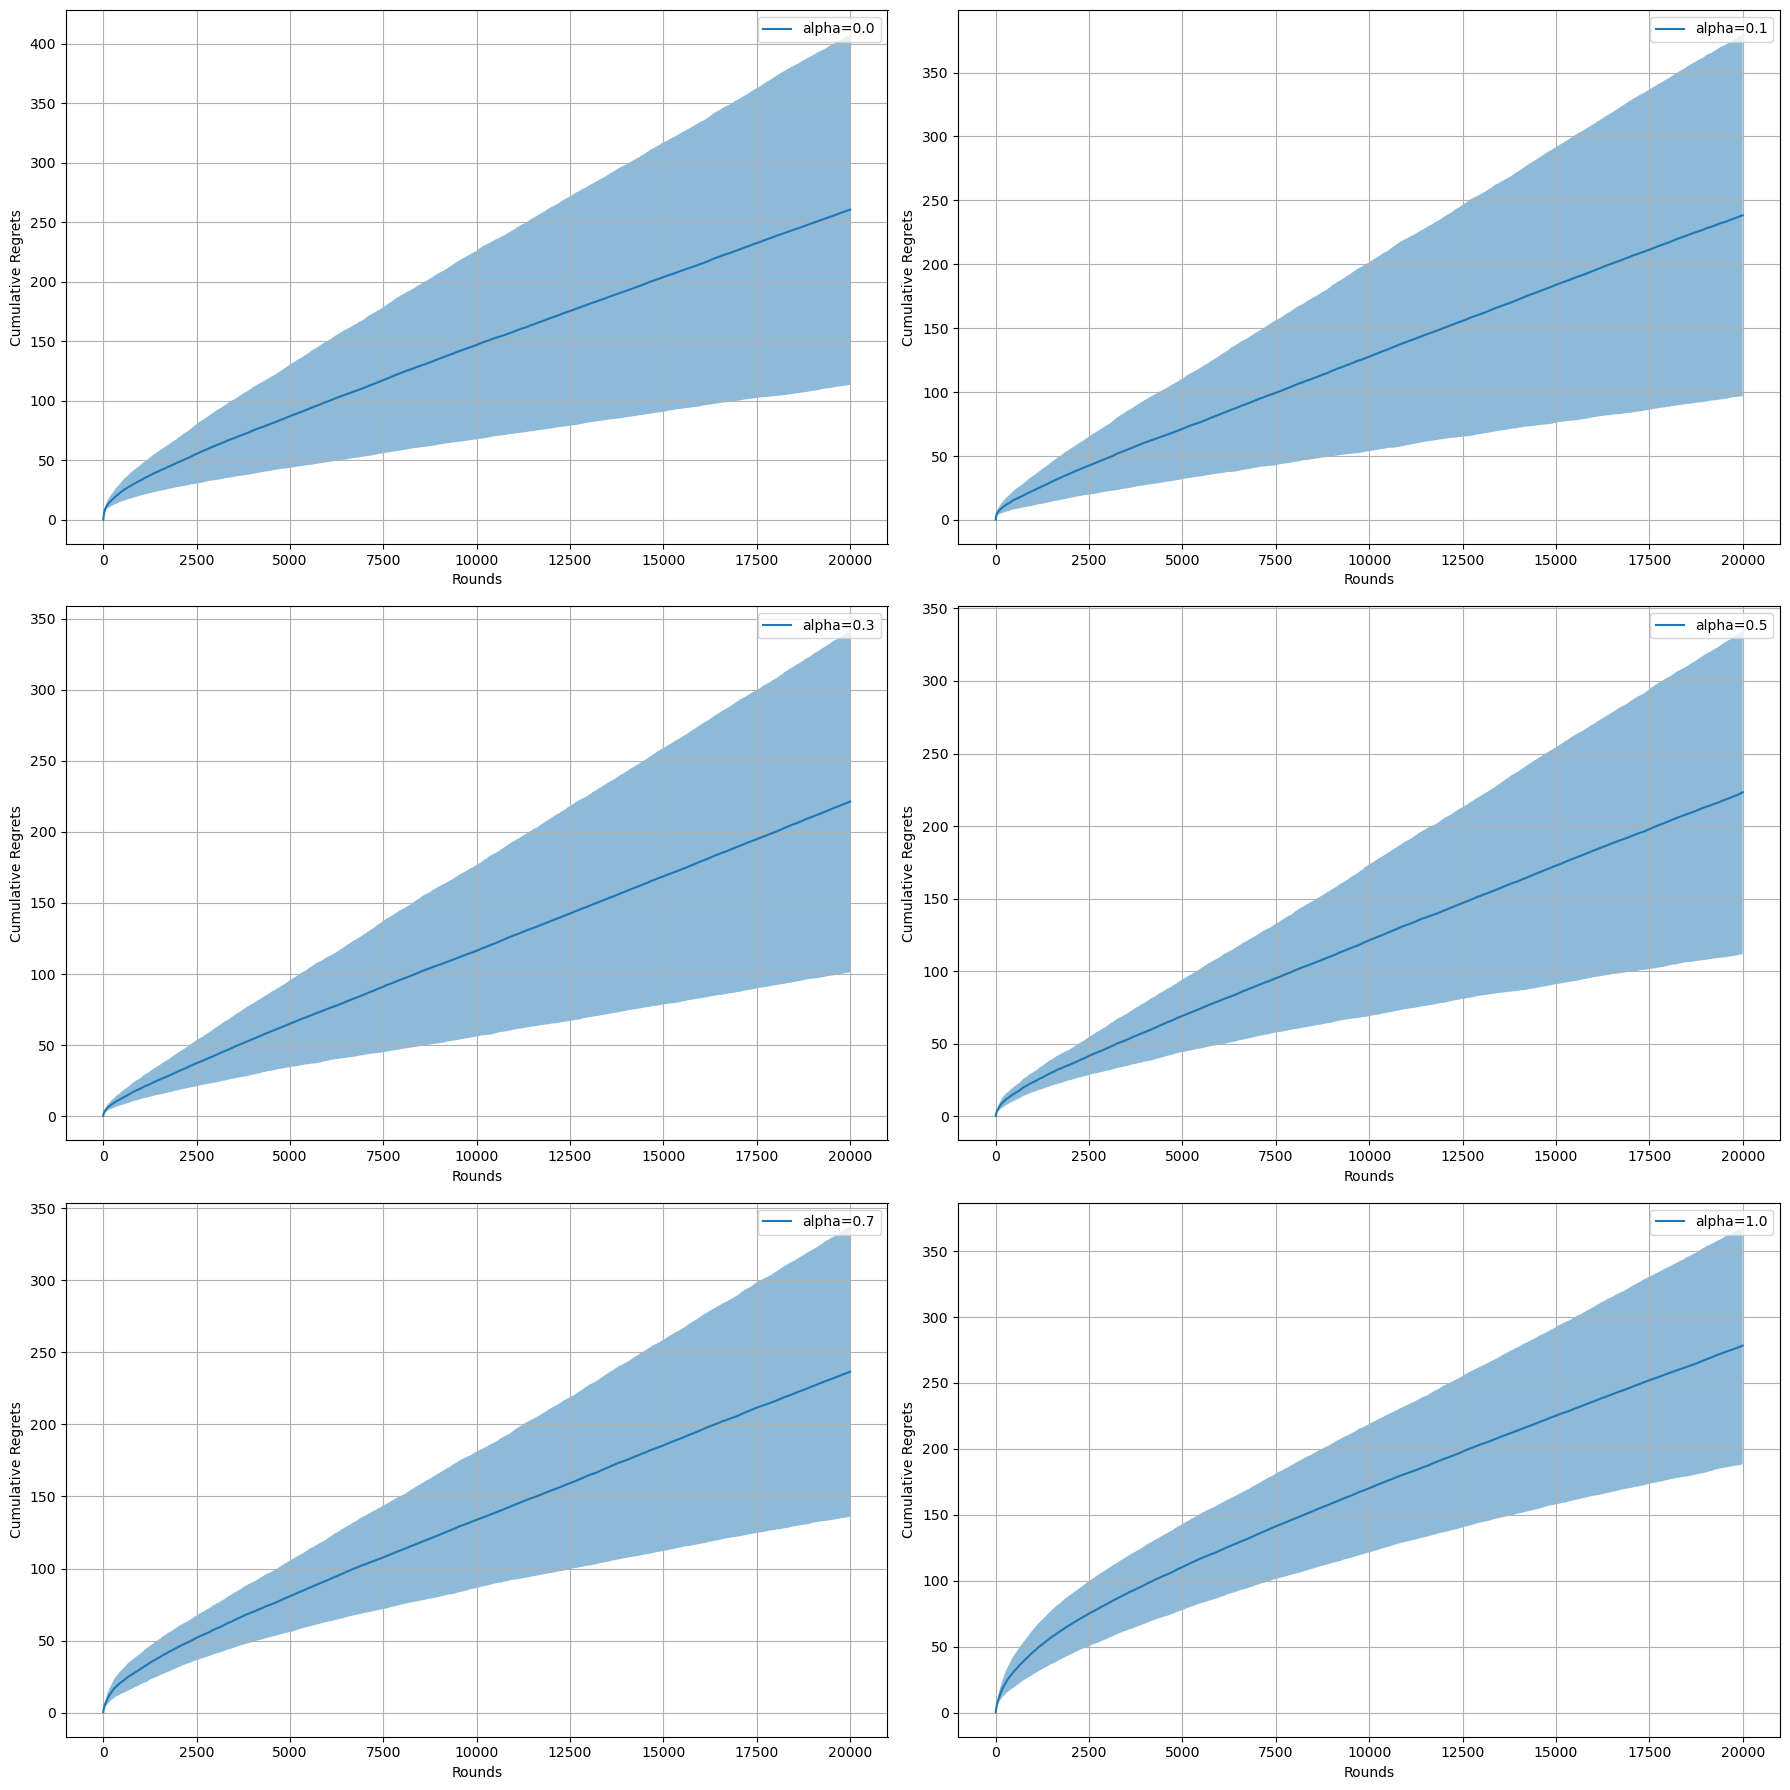

In [14]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

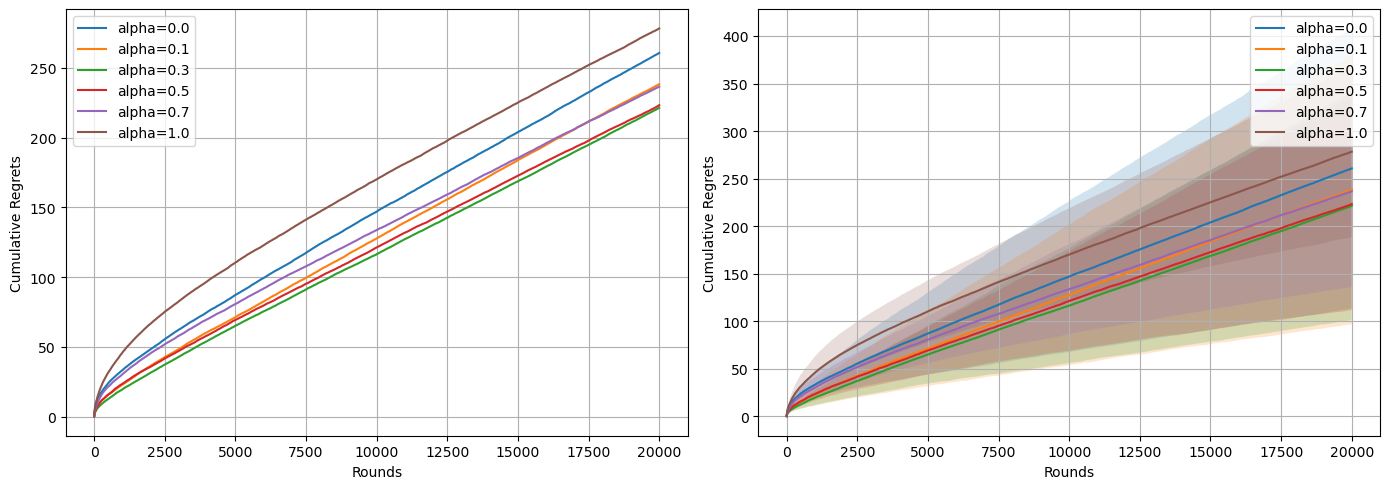

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

### $\sigma_\epsilon = 0.5$ (High noise variance)

In [16]:
reward_noise = 0.5

In [17]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4424.04it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4275.06it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4424.12it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4433.10it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4404.67it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4392.79it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4417.55it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4458.86it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4432.20it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4424.87it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4404.70it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4380.33it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4419.55it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4405.83it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4415.12it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4439.23it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4427.53it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4407.08it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4482.42it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4415.13it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4398.79it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4410.69it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4369.34it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4418.53it/s]


Trial 4
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4383.37it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4409.37it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4447.98it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4410.54it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4422.13it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4423.01it/s]


Trial 5
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4407.78it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4451.78it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4419.02it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4418.56it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4423.53it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4454.76it/s]


Trial 6
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4421.83it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4478.57it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4481.67it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4414.35it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4392.94it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4426.48it/s]


Trial 7
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4429.46it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4420.55it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4405.95it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4432.19it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4484.84it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4457.61it/s]


Trial 8
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4403.66it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4440.85it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4430.33it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4366.40it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4385.14it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4365.94it/s]


Trial 9
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4429.75it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4379.06it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4389.38it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4359.68it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4360.85it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4373.80it/s]


In [18]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([4.52998906e-01, 8.58165954e-01, 1.27770375e+00, ...,
       7.27213742e+02, 7.27298945e+02, 7.27298945e+02]), array([1.29688361e-01, 3.18859598e-01, 8.03657689e-01, ...,
       7.57946086e+02, 7.57946086e+02, 7.57998176e+02]), array([3.02147321e-01, 5.86580331e-01, 8.75335949e-01, ...,
       1.13966621e+03, 1.13978655e+03, 1.13978655e+03]), array([3.19066743e-01, 5.98907792e-01, 1.04878954e+00, ...,
       6.14147193e+02, 6.14194177e+02, 6.14239310e+02]), array([2.45304945e-01, 7.25707799e-01, 1.17348497e+00, ...,
       2.96187175e+02, 2.96241825e+02, 2.96241825e+02]), array([0.00000000e+00, 5.96723935e-02, 5.96723935e-02, ...,
       8.19084152e+02, 8.19084152e+02, 8.19141092e+02]), array([8.51057772e-02, 2.91974486e-01, 6.39756525e-01, ...,
       9.00083863e+02, 9.00110842e+02, 9.00110842e+02]), array([1.53398821e-01, 4.54366356e-01, 1.03151214e+00, ...,
       1.80458830e+03, 1.80458830e+03, 1.80458830e+03]), array([1.94006313e-01, 4.5080

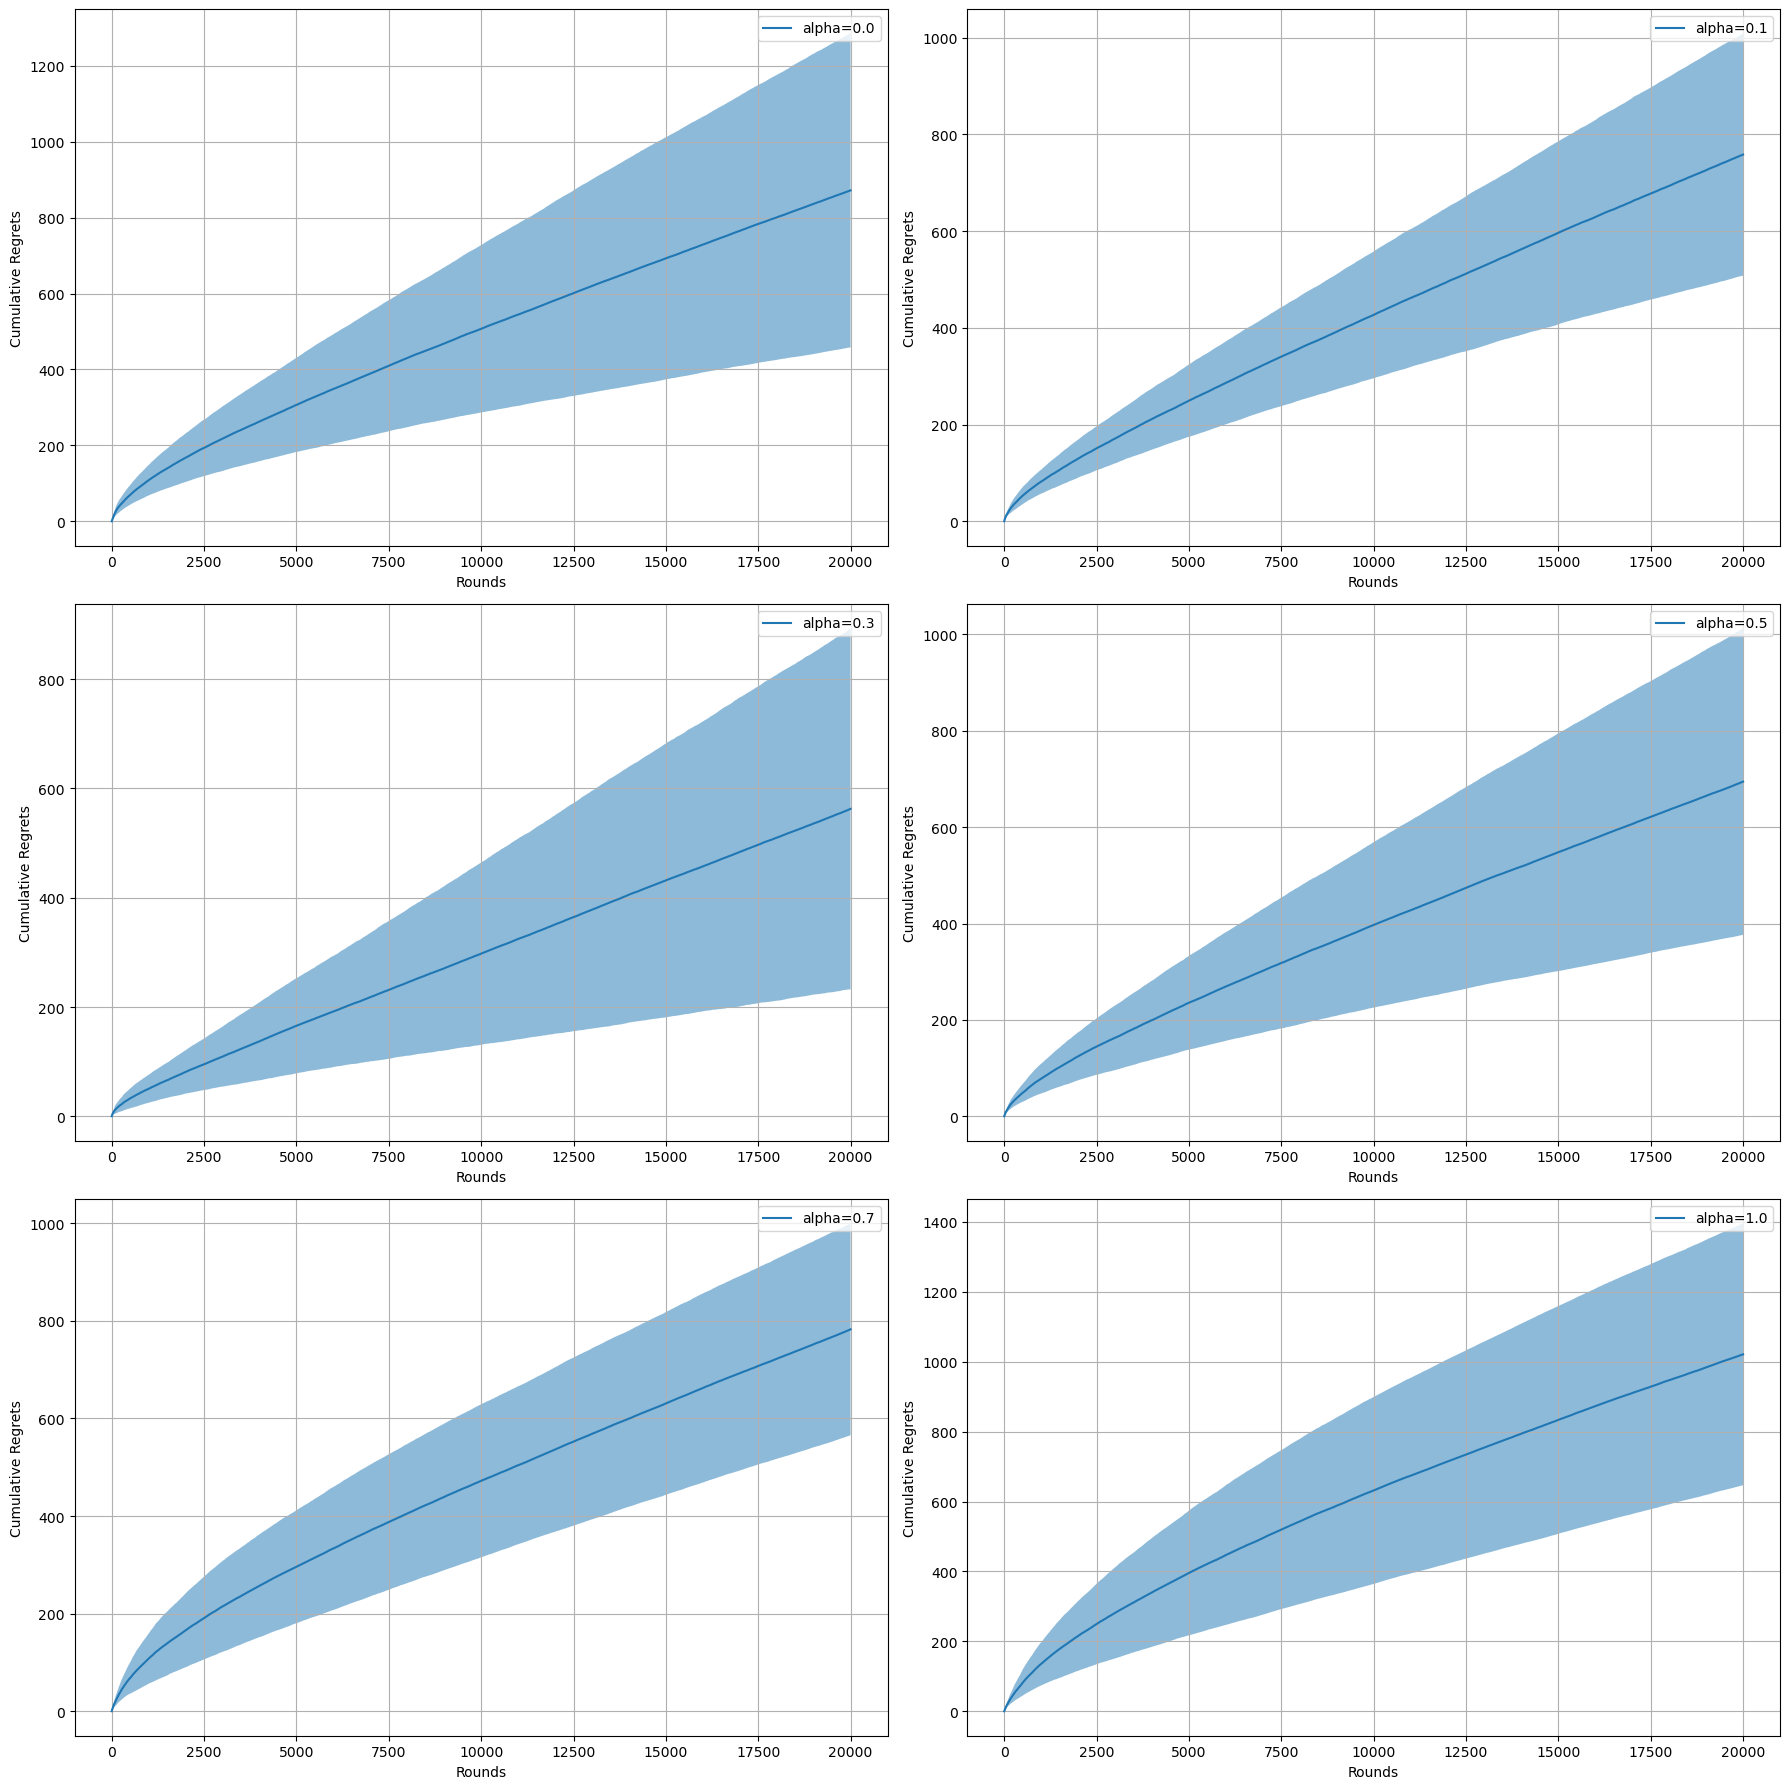

In [19]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

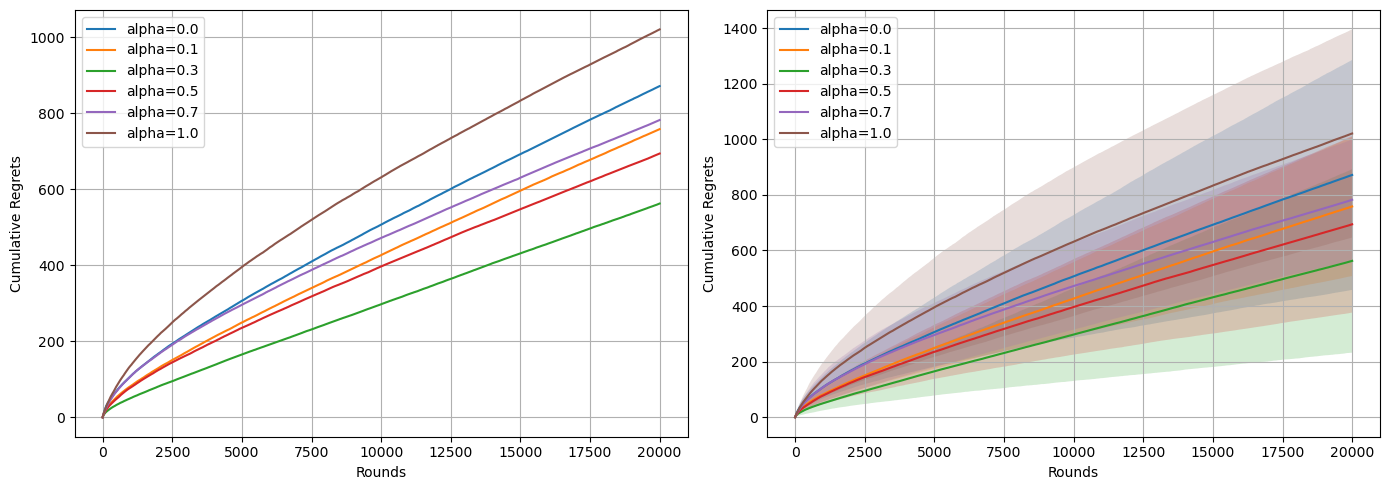

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

## Decoder mapping $\sim N(0, \Sigma_k)$

### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [21]:
reward_noise = 0.1

In [22]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4283.99it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4271.84it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4334.13it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4437.19it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4409.40it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4411.47it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4364.93it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4363.59it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4379.02it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4484.56it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4455.78it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4452.29it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4562.06it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4571.97it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4558.04it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4569.54it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4584.79it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4598.83it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4533.35it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4391.46it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4428.12it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4498.33it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4513.55it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4475.94it/s]


Trial 4
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4429.77it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4409.39it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4428.31it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4437.46it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4451.41it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4447.30it/s]


Trial 5
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4490.30it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4446.92it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4450.04it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4370.07it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4380.16it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4354.39it/s]


Trial 6
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4324.62it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4369.82it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4400.20it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4423.21it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4439.68it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4402.89it/s]


Trial 7
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4343.68it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4438.06it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4423.74it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4437.06it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4442.83it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4424.49it/s]


Trial 8
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4460.72it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4443.08it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4415.83it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4488.22it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4476.21it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4527.84it/s]


Trial 9
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4603.85it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4572.63it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4554.69it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4585.94it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4620.51it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4619.50it/s]


In [23]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([  0.25036199,   0.4009518 ,   0.70502623, ..., 118.2651135 ,
       118.2651135 , 118.2651135 ]), array([  0.34576888,   1.02327974,   1.54813786, ..., 262.37927463,
       262.37927463, 262.37927463]), array([ 0.32513237,  0.56008296,  0.88983417, ..., 96.83219606,
       96.85598065, 96.88169755]), array([4.28485897e-02, 4.28485897e-02, 4.28485897e-02, ...,
       3.48544436e+02, 3.48576587e+02, 3.48576587e+02]), array([  0.27019491,   0.41954899,   0.59077344, ..., 125.73408823,
       125.73408823, 125.74805343]), array([ 0.19680773,  0.45838829,  0.58565539, ..., 87.33428491,
       87.33428491, 87.34798818]), array([ 0.15126337,  0.41975643,  0.72152156, ..., 84.5500265 ,
       84.5500265 , 84.56154931]), array([  0.        ,   0.15999833,   0.17073202, ..., 105.8659501 ,
       105.8659501 , 105.90169527]), array([  0.3426389 ,   1.08181531,   1.60261982, ..., 331.59327809,
       331.59327809, 331.59327809]), array([ 0.52731127,  1.020

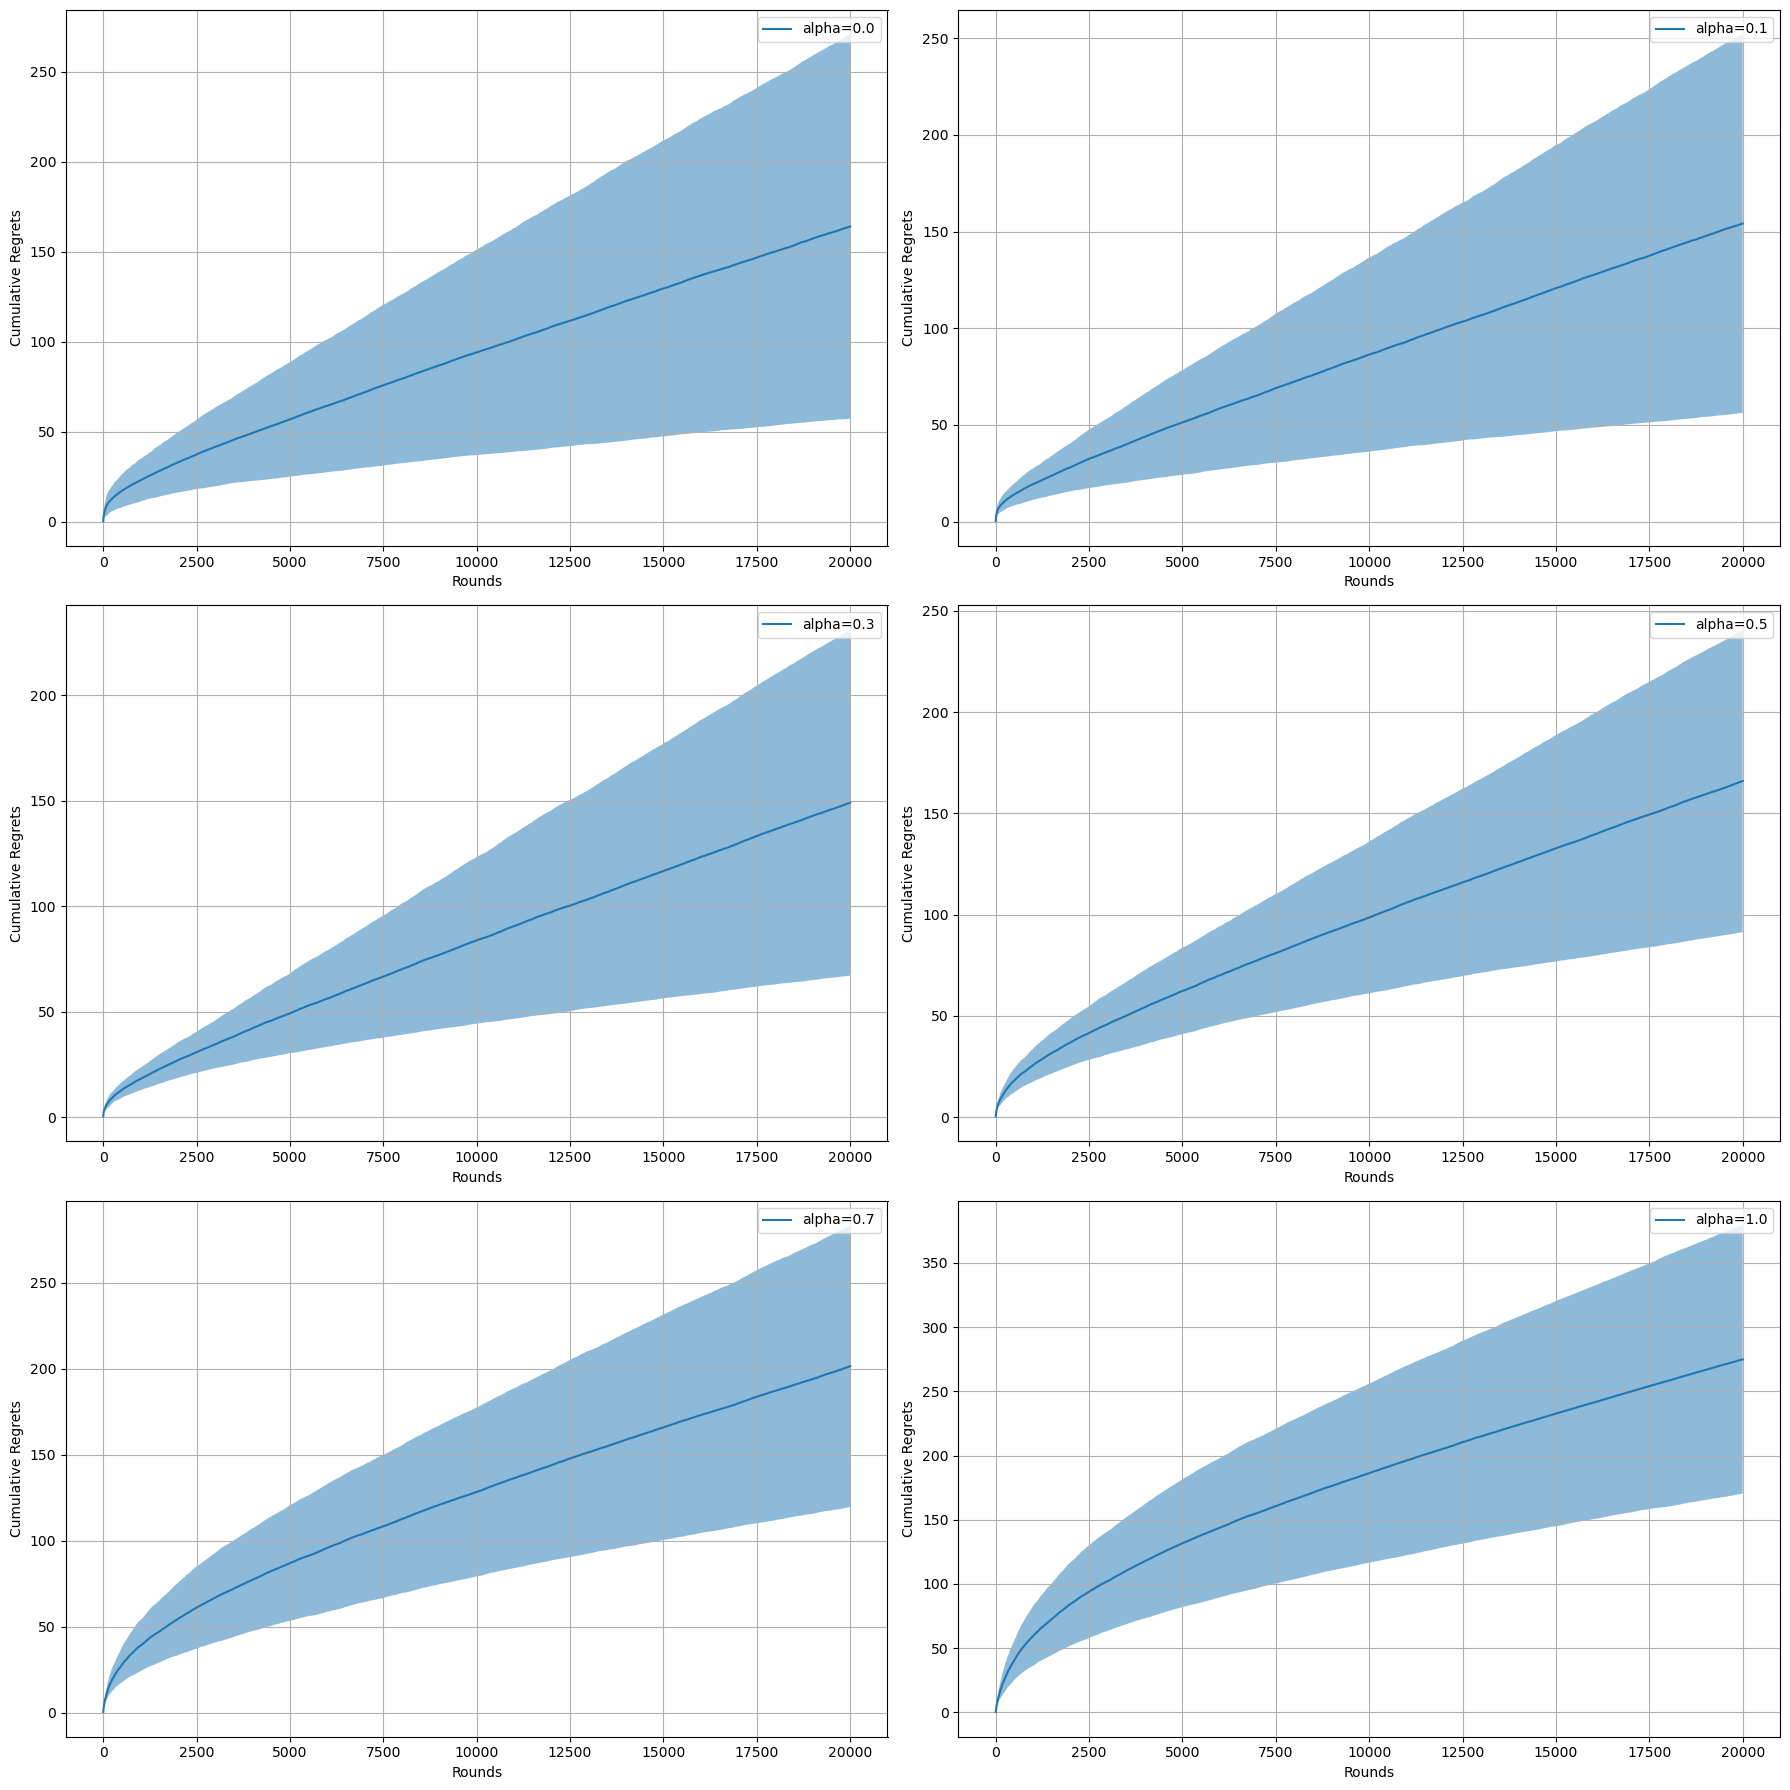

In [24]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

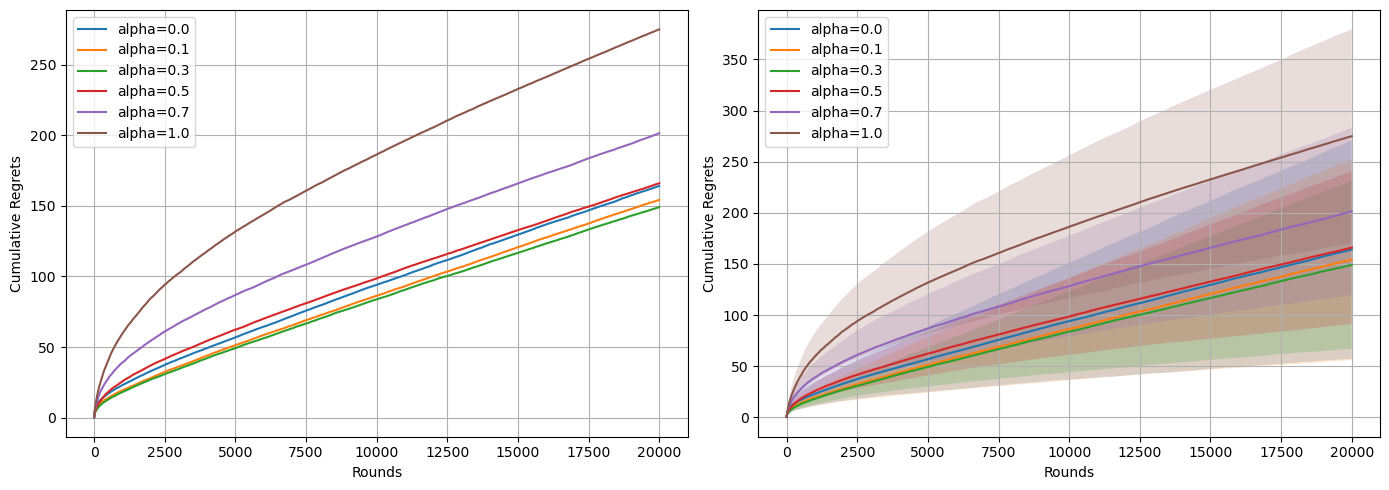

In [25]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

### $\sigma_\epsilon = 0.5$ (High noise variance)

In [26]:
reward_noise = 0.5

In [27]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4540.65it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4594.26it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4586.26it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4554.09it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4562.62it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4576.49it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4629.95it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4451.14it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4461.28it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4458.98it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4419.74it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4457.27it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4410.65it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4414.42it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4393.10it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4387.01it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4458.81it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4512.59it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4459.14it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4492.66it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4517.94it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4519.56it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4513.96it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4494.03it/s]


Trial 4
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4509.61it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4498.85it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4500.17it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4496.87it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4476.53it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4496.66it/s]


Trial 5
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4348.34it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4391.46it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4434.75it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4457.60it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4420.27it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4456.40it/s]


Trial 6
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4512.39it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4573.83it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4589.98it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4564.03it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4582.15it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4605.49it/s]


Trial 7
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4562.13it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4585.93it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4555.75it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4558.21it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4589.82it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4563.17it/s]


Trial 8
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4190.49it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4610.31it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4609.59it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4639.50it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4594.47it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4543.05it/s]


Trial 9
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4459.36it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4428.92it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4424.96it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4448.15it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4463.75it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4345.32it/s]


In [28]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([2.50361994e-01, 4.00951800e-01, 7.05026227e-01, ...,
       9.03803527e+02, 9.03813587e+02, 9.03813587e+02]), array([3.45768880e-01, 1.02327974e+00, 1.54813786e+00, ...,
       6.60860172e+02, 6.60919679e+02, 6.60919679e+02]), array([3.25132366e-01, 5.60082964e-01, 8.89834172e-01, ...,
       3.98738086e+02, 3.98761870e+02, 3.98868050e+02]), array([4.28485897e-02, 4.28485897e-02, 4.28485897e-02, ...,
       5.51840306e+02, 5.51872457e+02, 5.51872457e+02]), array([2.70194910e-01, 4.19548990e-01, 5.90773442e-01, ...,
       6.48194248e+02, 6.48280908e+02, 6.48294873e+02]), array([  0.19680773,   0.45838829,   0.58565539, ..., 194.337116  ,
       194.337116  , 194.35081927]), array([1.51263365e-01, 4.19756427e-01, 7.21521557e-01, ...,
       5.77165604e+02, 5.77165604e+02, 5.77175198e+02]), array([0.00000000e+00, 1.59998332e-01, 1.70732021e-01, ...,
       3.13725263e+02, 3.13725263e+02, 3.13761008e+02]), array([3.42638899e-01, 1.08181531e+00, 1.

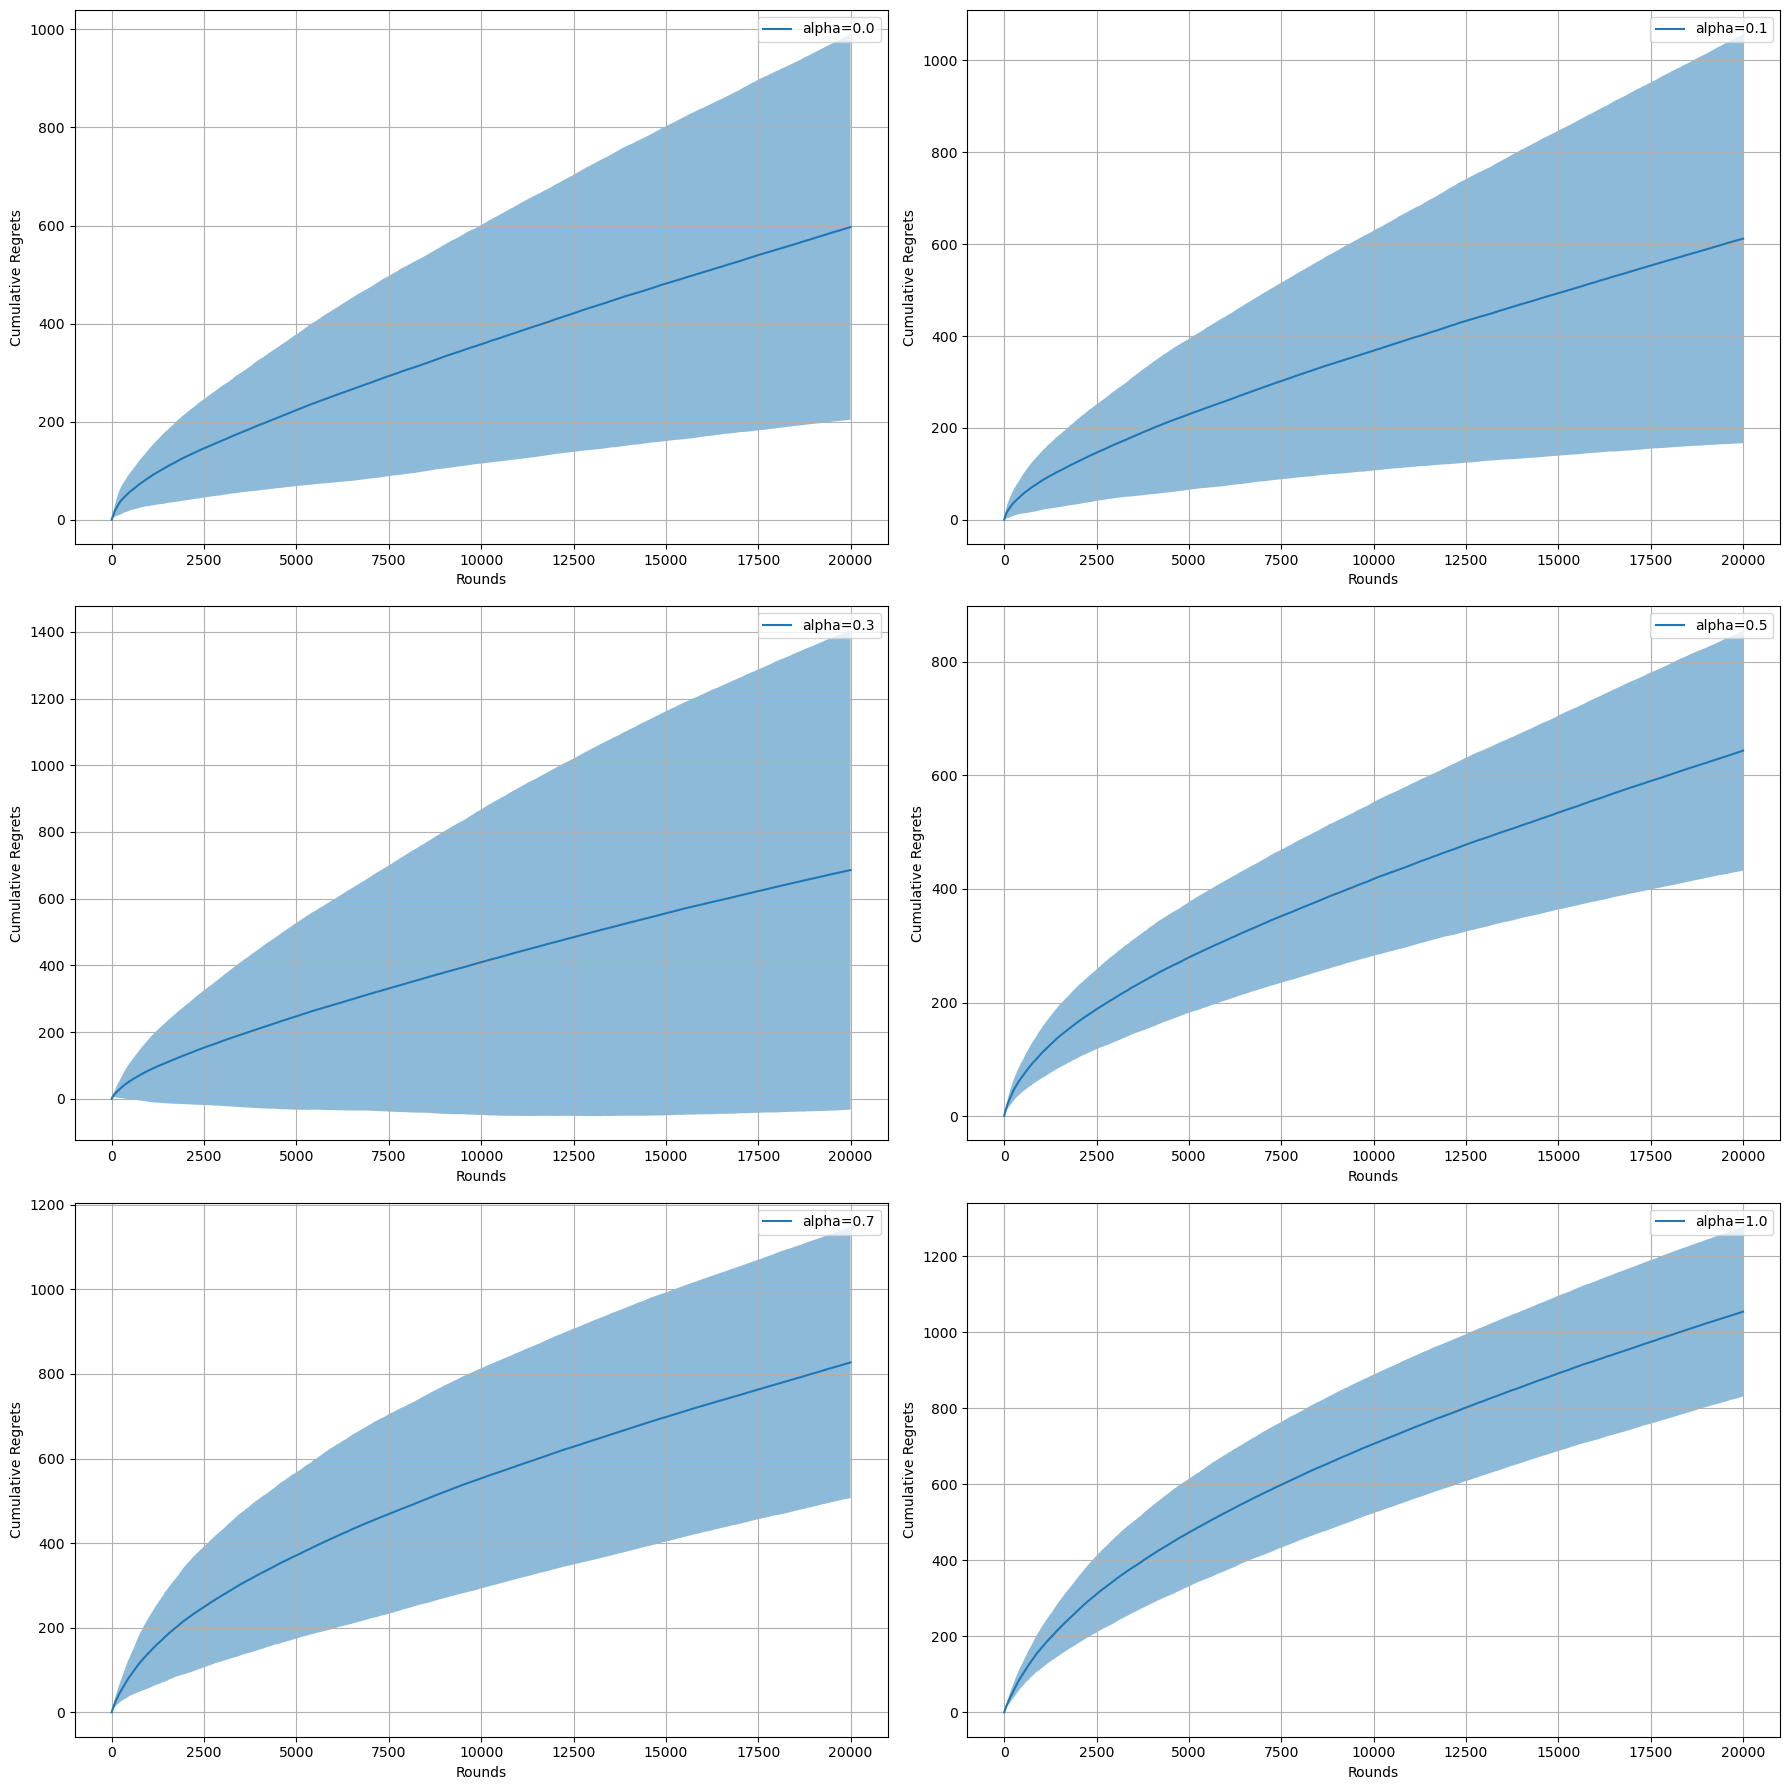

In [29]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

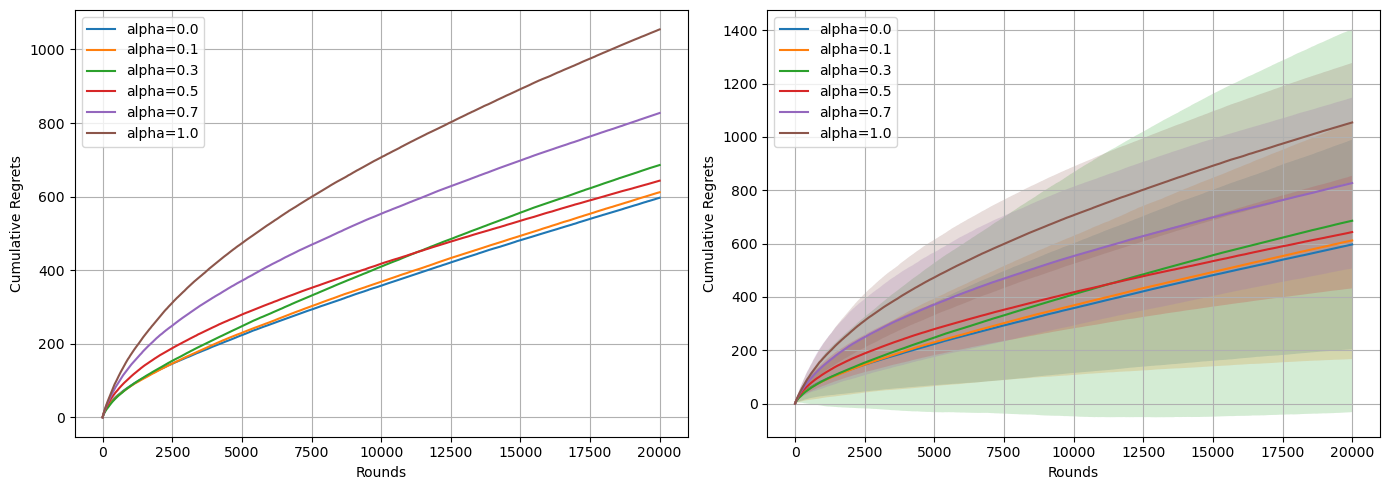

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

# $\sigma_{\eta} = \frac{1}{{T}}$

## Decoder mapping $\sim N(0, I_k)$

### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [ ]:
reward_noise = 0.1

In [ ]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1/T), 
                            reward_noise=reward_noise, disjoint=True, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:05<00:00, 3986.87it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4048.81it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4007.08it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4046.73it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4081.07it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4023.80it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4042.92it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4060.17it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4011.76it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4039.34it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4025.79it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4018.30it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:05<00:00, 3978.04it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4044.97it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4071.51it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4053.93it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4071.85it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4066.55it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4026.06it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4063.51it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4102.73it/s]


=====================alpha=0.5=====================


  4%|█                         | 810/20000 [00:00<00:04, 4021.44it/s]

In [ ]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

In [ ]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

### $\sigma_\epsilon = 0.5$ (High noise variance)

In [ ]:
reward_noise = 0.5

In [ ]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1/T), 
                            reward_noise=reward_noise, disjoint=True, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:05<00:00, 3986.87it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4048.81it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4007.08it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4046.73it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4081.07it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4023.80it/s]


Trial 1
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4042.92it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4060.17it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4011.76it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4039.34it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4025.79it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4018.30it/s]


Trial 2
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:05<00:00, 3978.04it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4044.97it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4071.51it/s]


=====================alpha=0.5=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4053.93it/s]


=====================alpha=0.7=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4071.85it/s]


=====================alpha=1.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4066.55it/s]


Trial 3
=====================alpha=0.0=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4026.06it/s]


=====================alpha=0.1=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4063.51it/s]


=====================alpha=0.3=====================


100%|████████████████████████| 20000/20000 [00:04<00:00, 4102.73it/s]


=====================alpha=0.5=====================


  4%|█                         | 810/20000 [00:00<00:04, 4021.44it/s]

In [ ]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

In [ ]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

## Decoder mapping $\sim N(0, \Sigma_k)$

### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [ ]:
reward_noise = 0.1

In [ ]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1/T), 
                            reward_noise=reward_noise, disjoint=False, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

In [ ]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

In [ ]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

### $\sigma_\epsilon = 0.5$ (Low noise variance)

In [ ]:
reward_noise = 0.5

In [ ]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1/T), 
                            reward_noise=reward_noise, disjoint=False, 
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=trial)
    results.append(regret_result)

In [ ]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

In [ ]:
plt.figure(figsize=(18, 18))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"32{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()